In [1]:
import numpy as np
from scipy.stats import norm
import random
import matplotlib.pyplot as plt

In [2]:
N = norm.cdf

## Black–Scholes Model for European Option Pricing

The **Black–Scholes model** provides a closed-form solution for the fair value of a **European call or put option** under the following assumptions:
- The underlying asset price follows **Geometric Brownian Motion** under the risk-neutral measure:
  
  $$
  dS_t = r S_t \, dt + \sigma S_t \, dW_t
  $$
  
- Volatility $\sigma$ and risk-free rate $r$ are constant.
- No dividends are paid during the option’s life.
- Markets are frictionless (no transaction costs, continuous trading).

---

### **Closed-form formula**

For a **call**:
$$
C_0 = S_0 \, N(d_1) - K e^{-rT} N(d_2)
$$

For a **put**:
$$
P_0 = K e^{-rT} N(-d_2) - S_0 N(-d_1)
$$

Where:
$$
d_1 = \frac{\ln(S_0 / K) + (r + \tfrac{1}{2}\sigma^2)T}{\sigma \sqrt{T}},
\quad
d_2 = d_1 - \sigma \sqrt{T}
$$

---

### **Parameters**
- $S_0$ — Current asset price
- $K$ — Strike price
- $r$ — Risk-free interest rate (annualized, continuous compounding)
- $\sigma$ — Volatility of asset returns (annualized)
- $T$ — Time to maturity in years
- $N(\cdot)$ — Cumulative distribution function (CDF) of the standard normal distribution

---

**Interpretation of $d_1$ and $d_2$:**
- $d_1$ measures the option’s **moneyness** adjusted for time and volatility.
- $d_2$ is the probability (under risk-neutral measure) that the option will expire in-the-money, discounted for volatility.

---

### **Advantages**
- Fast, closed-form calculation for European options.
- Useful as a benchmark for more complex models (e.g., Monte Carlo, binomial trees).

### **Limitations**
- Assumes constant volatility and interest rate.
- Cannot handle early exercise (American options).
- Not accurate for assets with large jumps or stochastic volatility.


In [3]:
# a fair price of European style put option according to Black-Scholes framework

def put_option(K, S0, r, sigm, T):
    d1 =  (np.log(S0/K) + (r + (sigm**2) / 2)*T) / (sigm*np.sqrt(T))

    d2 = d1 - sigm*np.sqrt(T)

    p = K * np.exp(-r*T) * N(-d2) - S0 * N(-d1)

    return p

In [4]:
# a fair price of European style put option according to Black-Scholes framework

def call_option(K, S0, r, sigm, T):
    d1 =  (np.log(S0/K) + (r + (sigm**2) / 2)*T) / (sigm*np.sqrt(T))

    d2 = d1 - sigm*np.sqrt(T)

    p =  S0 * N(d1) - K * np.exp(-r*T) * N(d2)

    return p

## Geometric Brownian Motion (GBM) Model

We model the stock price \( S_t \) under the **risk–neutral measure** as the stochastic differential equation (SDE):

$$
dS_t = r S_t \, dt + \sigma S_t \, dW_t
$$

where:
- $S_t$ — asset price at time t
- $r$ — constant risk-free interest rate
- $\sigma$ — volatility (standard deviation of returns)
- $W_t$ — standard Brownian motion (Wiener process)

---

### Exact solution

Over a small time step \(\Delta t\), the **exact** GBM solution is:

$$
S_{t+\Delta t} = S_t \cdot \exp\left[ \left( r - \frac{1}{2} \sigma^2 \right) \Delta t + \sigma \sqrt{\Delta t} \, Z \right]
$$

where:
- $Z \sim \mathcal{N}(0,1)$ is a standard normal random variable  
- $\left( r - \frac{1}{2} \sigma^2 \right) \Delta t$ is the deterministic drift  
- $\sigma \sqrt{\Delta t} \, Z$ is the random shock from Brownian motion increments $\Delta W_t\$

---

**Parameters in the solution:**
- $S_0$: initial asset price at t = 0
- r: risk-free interest rate (controls average growth rate under risk-neutral measure)  
- $\sigma$: volatility (controls magnitude of randomness)  
- $\Delta t$: time step size (in years)  
- $Z$: standard normal random variable representing the shock in each step

In [5]:
def mc_pricing(S0, r, sigm, T, N, N_path):
    dt = T / N
    times = np.linspace(0, T, N+1)
    
    # Initialize array: rows = time steps, columns = paths
    S = np.zeros((N + 1, N_path))
    S[0] = S0  # initial value for all paths

    for t in range(1, N + 1):
        Z = np.random.normal(size=N_path)  # generate one z per path
        S[t] = S[t - 1] * np.exp((r - 0.5 * sigm**2) * dt + sigm * np.sqrt(dt) * Z)
    
    return S

In [6]:
S0 = 100
r = 0.03
sigm = 0.25
T = 0.5
N_steps = 10000
N_path = 1000

mc_prices = mc_pricing(S0, r, sigm, T, N_steps, N_path)

In [7]:
# let see at the fluctuations of the option price 

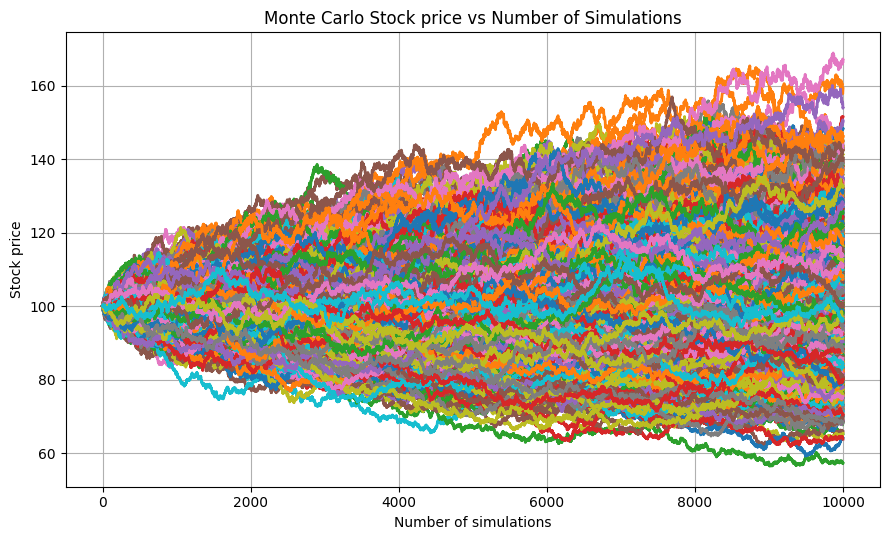

In [8]:
time_points = np.arange(mc_prices.shape[0])


plt.figure(figsize=(9, 5.5))

for i in range(mc_prices.shape[1]):
    plt.plot( time_points, mc_prices[:, i], lw=2.0)

plt.title("Monte Carlo Stock price vs Number of Simulations")
plt.xlabel("Number of simulations")
plt.ylabel("Stock price")
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
# Ok, we computed the price of the underlying asset using MC simulation
# then we need to compute the pay-off of this asset

In [10]:
def get_payoff(S, K, r, T, opt_type='call'):

    S = S[-1, :]  # we take prices at maturity
    
    if opt_type.lower() == 'call':
        payoff = np.maximum( (S-K) , 0 )
    elif opt_type.lower() == 'put':
        payoff = np.maximum( (K-S), 0 )
    else:
        raise ValueError("Option type should be either call or put")
        return 0
    price = np.mean(payoff) * np.exp(-r*T)  # we compute the value of the option today -> discount to exp^(-r*T)
    return price

In [11]:
K = 110 # strike price
S_T = 100 # current asset value

In [12]:
mc_payoff = get_payoff(mc_prices, K, r, T, opt_type='put')

In [13]:
# Compare the Black–Scholes analytical price with the Monte Carlo simulated price.
# For the Monte Carlo method, we estimate the option value by averaging
# the discounted payoffs from a large number of simulated price paths.

In [14]:
put_price = put_option(K, S_T, r, sigm, T)

In [15]:
print(f"Put option price with respect to BS formula: {put_price}")
print(f"The mean value of MC simulated option price: {mc_payoff}")

Put option price with respect to BS formula: 12.260864539521961
The mean value of MC simulated option price: 12.96090951537734
